In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.image as img
import random
import pathlib
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_dir = "drive/My Drive/Major/Dataset2"

Mounted at /content/drive


In [ ]:
data_dir=dataset_dir
!pip install split-folders
import splitfolders
splitfolders.ratio(dataset_dir, output="output", seed=1345, ratio=(.8, 0.1,0.1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 25640 files [08:53, 48.09 files/s] 


In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 20511 files belonging to 4 classes.
Found 2566 files belonging to 4 classes.
Found 2563 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

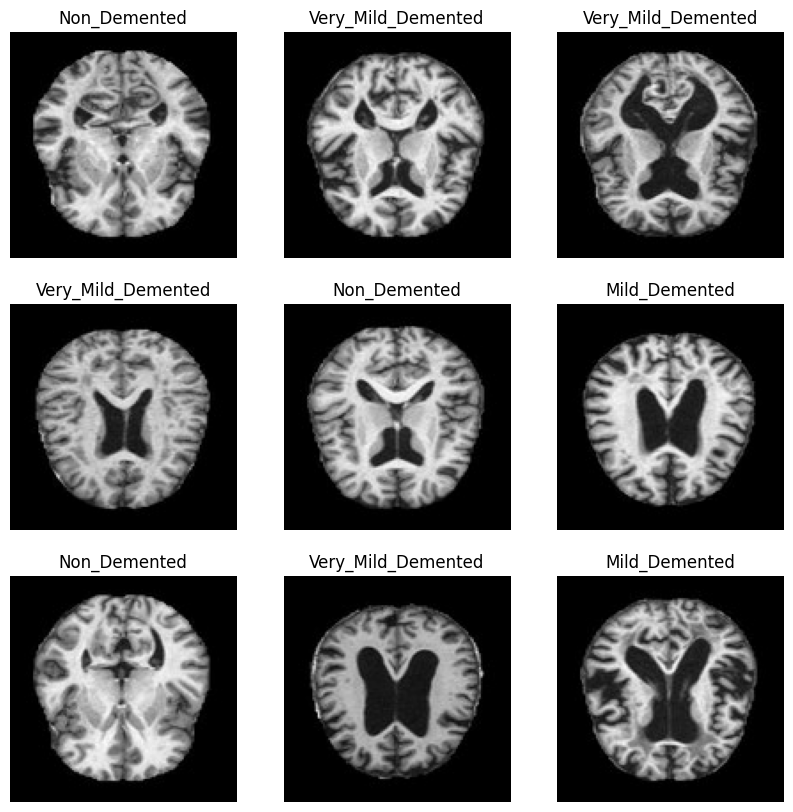

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<function matplotlib.pyplot.show(close=None, block=None)>

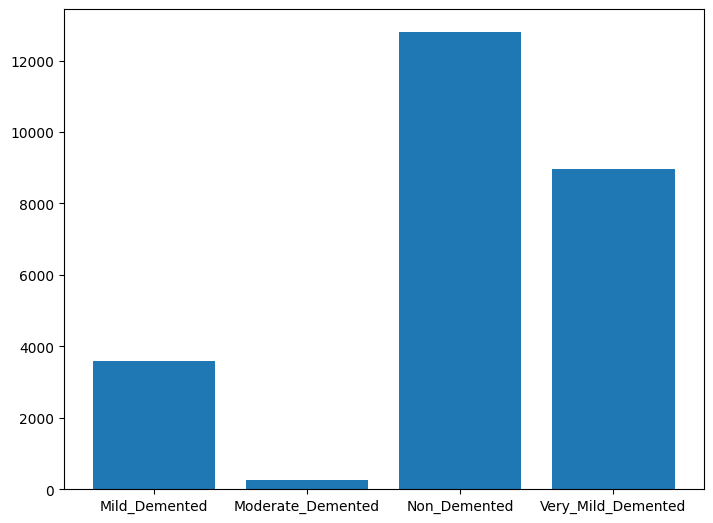

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [3584,256,12800,8960]
ax.bar(class_names,size)
plt.show

In [ ]:
import tensorflow as tf
import numpy as np
import random
from tensorflow import keras
import pathlib

# Define the hyperparameters and their possible values
hyperparameters = {
    'filters': [16, 32, 64, 128],
    'kernel_size': [(3, 3), (5, 5), (7, 7)],
    'dropout': [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3],
    'dense_units': [32, 64, 128, 256],
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'batch_size': [32, 64, 128]
}

# Function to create an individual with random hyperparameters
def create_individual():
    individual = {
        'filters': [random.choice(hyperparameters['filters']) for _ in range(3)],
        'kernel_size': random.choice(hyperparameters['kernel_size']),
        'dropout': random.choice(hyperparameters['dropout']),
        'dense_units': [random.choice(hyperparameters['dense_units']) for _ in range(2)],
        'learning_rate': random.choice(hyperparameters['learning_rate']),
        'batch_size': random.choice(hyperparameters['batch_size'])
    }
    return individual

# Function to create the initial population
def create_population(size):
    return [create_individual() for _ in range(size)]

# Function to build and train the CNN with the given hyperparameters
def train_cnn(individual, train_ds, val_ds):
    print("Training with hyperparameters:", individual)
    model = keras.models.Sequential()
    model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    model.add(keras.layers.Conv2D(filters=individual['filters'][0], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=individual['filters'][1], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Dropout(individual['dropout']))

    model.add(keras.layers.Conv2D(filters=individual['filters'][2], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Dropout(individual['dropout']))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(individual['dense_units'][0], activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(individual['dense_units'][1], activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(4, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=individual['learning_rate']), metrics=["accuracy"])
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    hist = model.fit(train_ds, validation_data=val_ds, epochs=15, batch_size=individual['batch_size'], verbose=0, callbacks=[early_stopping])

    val_accuracy = hist.history['val_accuracy'][-1]
    print("Validation accuracy:", val_accuracy)
    return val_accuracy

# Function to evaluate the fitness of the population
def evaluate_population(population, train_ds, val_ds):
    fitness = []
    for individual in population:
        val_accuracy = train_cnn(individual, train_ds, val_ds)
        fitness.append(val_accuracy)
    return fitness

# Function to select the best individuals based on their fitness
def selection(population, fitness, num_parents):
    sorted_indices = np.argsort(fitness)[::-1]
    return [population[i] for i in sorted_indices[:num_parents]]

# Function to perform crossover between two parents
def crossover(parent1, parent2):
    child = {}
    for key in parent1.keys():
        if key in ['filters', 'dense_units']:
            child[key] = [random.choice([parent1[key][i], parent2[key][i]]) for i in range(len(parent1[key]))]
        else:
            child[key] = random.choice([parent1[key], parent2[key]])
    return child

# Function to perform mutation on an individual
def mutation(individual):
    mutation_key = random.choice(list(hyperparameters.keys()))
    if mutation_key in ['filters', 'dense_units']:
        index = random.randint(0, len(individual[mutation_key]) - 1)
        individual[mutation_key][index] = random.choice(hyperparameters[mutation_key])
    else:
        individual[mutation_key] = random.choice(hyperparameters[mutation_key])
    return individual

# Function to create a new generation using crossover and mutation
def create_new_generation(parents, population_size):
    new_generation = parents
    while len(new_generation) < population_size:
        parent1, parent2 = random.sample(parents, 2)
        child = crossover(parent1, parent2)
        child = mutation(child)
        new_generation.append(child)
    return new_generation


# Genetic algorithm parameters
population_size = 10
num_generations = 10
num_parents = 2

# Create the initial population
population = create_population(population_size)

# Run the genetic algorithm
for generation in range(num_generations):
    print(f"Generation {generation + 1}")
    fitness = evaluate_population(population, train_ds, val_ds)
    parents = selection(population, fitness, num_parents)
    population = create_new_generation(parents, population_size)
    print("Best accuracy in generation:", max(fitness))

# Train the final model with the best hyperparameters
best_individual = parents[0]
print("Best individual:", best_individual)
val_accuracy = train_cnn(best_individual, train_ds, val_ds)
print("Validation accuracy:", val_accuracy)


Generation 1
Training with hyperparameters: {'filters': [32, 64, 32], 'kernel_size': (5, 5), 'dropout': 0.175, 'dense_units': [256, 64], 'learning_rate': 0.0001, 'batch_size': 32}
Validation accuracy: 0.7856025099754333
Training with hyperparameters: {'filters': [128, 16, 64], 'kernel_size': (3, 3), 'dropout': 0.15, 'dense_units': [256, 128], 'learning_rate': 0.0001, 'batch_size': 128}
Validation accuracy: 0.8575899600982666
Training with hyperparameters: {'filters': [128, 32, 32], 'kernel_size': (3, 3), 'dropout': 0.25, 'dense_units': [64, 64], 'learning_rate': 0.0001, 'batch_size': 128}
Validation accuracy: 0.7417840361595154
Training with hyperparameters: {'filters': [32, 64, 16], 'kernel_size': (5, 5), 'dropout': 0.175, 'dense_units': [32, 128], 'learning_rate': 1e-05, 'batch_size': 128}
Validation accuracy: 0.5007824897766113
Training with hyperparameters: {'filters': [64, 64, 32], 'kernel_size': (5, 5), 'dropout': 0.25, 'dense_units': [32, 32], 'learning_rate': 0.0001, 'batch_siz

In [ ]:
import matplotlib.pyplot as plt

# Function to build the CNN with the given hyperparameters
def build_cnn(individual):
    model = keras.models.Sequential()
    model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    model.add(keras.layers.Conv2D(filters=individual['filters'][0], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=individual['filters'][1], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Dropout(individual['dropout']))

    model.add(keras.layers.Conv2D(filters=individual['filters'][2], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Dropout(individual['dropout']))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(individual['dense_units'][0], activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(individual['dense_units'][1], activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(4, activation="softmax"))

    return model

# Function to plot the training and validation accuracy and loss graphs
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

# Train the final model with the best hyperparameters
best_individual = parents[0]
print("Best individual:", best_individual)

# Build the model with the best hyperparameters
model = build_cnn(best_individual)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=best_individual['learning_rate']), metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(train_ds, validation_data=val_ds, epochs=25, batch_size=best_individual['batch_size'], verbose=2, callbacks=[early_stopping])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print("Test accuracy:", test_accuracy)


Best individual: {'filters': [32, 16, 64], 'kernel_size': (3, 3), 'dropout': 0.15, 'dense_units': [32, 256], 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/25
321/321 - 5s - loss: 1.3216 - accuracy: 0.4858 - val_loss: 1.1890 - val_accuracy: 0.5039 - 5s/epoch - 64ms/step
Epoch 2/25
321/321 - 3s - loss: 1.1197 - accuracy: 0.5446 - val_loss: 1.0337 - val_accuracy: 0.6150 - 3s/epoch - 34ms/step
Epoch 3/25
321/321 - 4s - loss: 1.0264 - accuracy: 0.5903 - val_loss: 0.9910 - val_accuracy: 0.6056 - 4s/epoch - 45ms/step
Epoch 4/25
321/321 - 3s - loss: 0.9715 - accuracy: 0.6103 - val_loss: 0.9432 - val_accuracy: 0.6322 - 3s/epoch - 37ms/step
Epoch 5/25
321/321 - 3s - loss: 0.8913 - accuracy: 0.6382 - val_loss: 0.8989 - val_accuracy: 0.6495 - 3s/epoch - 34ms/step
Epoch 6/25
321/321 - 3s - loss: 0.8302 - accuracy: 0.6861 - val_loss: 0.7954 - val_accuracy: 0.6870 - 3s/epoch - 34ms/step
Epoch 7/25
321/321 - 3s - loss: 0.7683 - accuracy: 0.7156 - val_loss: 0.6837 - val_accuracy: 0.7731 - 3s/epoch 

In [ ]:
loss, accuracy = model.evaluate(test_ds)

41/41 [==============================] - 0s 17ms/step - loss: 0.2573 - accuracy: 0.9722


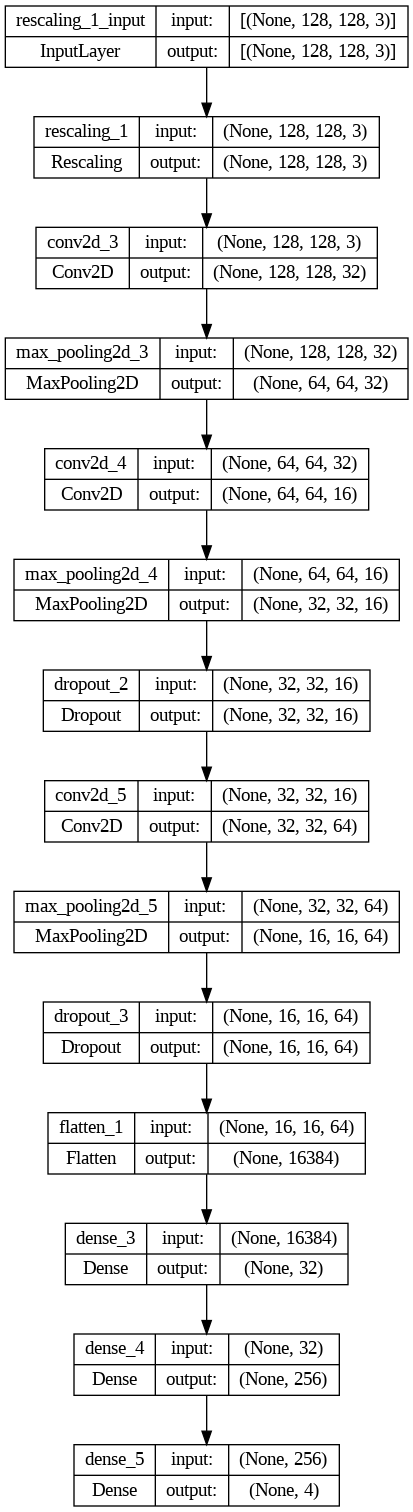

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
import numpy as np
import random
from tensorflow import keras
import pathlib

# Define the hyperparameters and their possible values
hyperparameters = {
    'filters': [16, 32, 64, 128],
    'kernel_size': [(3, 3), (5, 5), (7, 7)],
    'dropout': [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3],
    'dense_units': [32, 64, 128, 256],
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'batch_size': [32, 64, 128]
}

# Function to create a particle with random hyperparameters
def create_particle():
    particle = {
        'filters': [random.choice(hyperparameters['filters']) for _ in range(3)],
        'kernel_size': random.choice(hyperparameters['kernel_size']),
        'dropout': random.choice(hyperparameters['dropout']),
        'dense_units': [random.choice(hyperparameters['dense_units']) for _ in range(2)],
        'learning_rate': random.choice(hyperparameters['learning_rate']),
        'batch_size': random.choice(hyperparameters['batch_size'])
    }
    return particle

# Function to create the initial swarm
def create_swarm(size):
    return [create_particle() for _ in range(size)]

# Function to build and train the CNN with the given hyperparameters
def train_cnn(individual, train_ds, val_ds):
    print("Training with hyperparameters:", individual)
    model = keras.models.Sequential()
    model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    model.add(keras.layers.Conv2D(filters=individual['filters'][0], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=individual['filters'][1], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Dropout(individual['dropout']))

    model.add(keras.layers.Conv2D(filters=individual['filters'][2], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Dropout(individual['dropout']))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(individual['dense_units'][0], activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(individual['dense_units'][1], activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(4, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=individual['learning_rate']), metrics=["accuracy"])
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    hist = model.fit(train_ds, validation_data=val_ds, epochs=15, batch_size=individual['batch_size'], verbose=0, callbacks=[early_stopping])

    val_accuracy = hist.history['val_accuracy'][-1]
    print("Validation accuracy:", val_accuracy)
    return val_accuracy


# Function to evaluate the fitness of the swarm
def evaluate_swarm(swarm, train_ds, val_ds):
    fitness = []
    for particle in swarm:
        val_accuracy = train_cnn(particle, train_ds, val_ds)
        fitness.append(val_accuracy)
    return fitness

def update_particle(particle, p_best, g_best, w, c1, c2):
    new_particle = {}
    for key in particle.keys():
        if key in ['filters', 'dense_units']:
            new_particle[key] = [
                max(int(particle[key][i] + w * (p_best[key][i] - particle[key][i]) + c1 * random.random() * (g_best[key][i] - particle[key][i]) + c2 * random.random() * (p_best[key][i] - particle[key][i])), 1)
                for i in range(len(particle[key]))
            ]
        elif key == 'kernel_size':
            new_particle[key] = tuple(
                int(particle[key][i] + w * (p_best[key][i] - particle[key][i]) + c1 * random.random() * (g_best[key][i] - particle[key][i]) + c2 * random.random() * (p_best[key][i] - particle[key][i]))
                for i in range(len(particle[key]))
            )
        else:
            new_particle[key] = particle[key] + w * (p_best[key] - particle[key]) + c1 * random.random() * (g_best[key] - particle[key]) + c2 * random.random() * (p_best[key] - particle[key])
            if key == 'learning_rate':
                new_particle[key] = max(min(new_particle[key], max(hyperparameters[key])), min(hyperparameters[key]))
            else:
                new_particle[key] = int(max(min(new_particle[key], max(hyperparameters[key])), min(hyperparameters[key])))
    return new_particle

# PSO parameters
swarm_size = 10
num_iterations = 10
w = 0.5
c1 = 1
c2 = 2

# Create the initial swarm
swarm = create_swarm(swarm_size)
p_best = list(swarm)
p_best_fitness = evaluate_swarm(p_best, train_ds, val_ds)
g_best = p_best[np.argmax(p_best_fitness)]

# Run the PSO algorithm
stopping_criteria_reached = False
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}")
    swarm_fitness = evaluate_swarm(swarm, train_ds, val_ds)
    for i, particle in enumerate(swarm):
        if swarm_fitness[i] > p_best_fitness[i]:
            p_best[i] = particle
            p_best_fitness[i] = swarm_fitness[i]
        if swarm_fitness[i] > max(p_best_fitness):
            g_best = particle
    print("Best accuracy in iteration:", max(swarm_fitness))
    if max(swarm_fitness)>0.999:
      print("Max accuracy reached")
      break
    swarm = [update_particle(particle, p_best[i], g_best, w, c1, c2) for i, particle in enumerate(swarm)]

# Train the final model with the best hyperparameters
print("Best particle:", g_best)
val_accuracy = train_cnn(g_best, train_ds, val_ds)
print("Validation accuracy:", val_accuracy)


Training with hyperparameters: {'filters': [16, 16, 32], 'kernel_size': (5, 5), 'dropout': 0.125, 'dense_units': [256, 32], 'learning_rate': 1e-05, 'batch_size': 128}
Validation accuracy: 0.5007824897766113
Training with hyperparameters: {'filters': [64, 16, 128], 'kernel_size': (3, 3), 'dropout': 0.125, 'dense_units': [128, 256], 'learning_rate': 0.0001, 'batch_size': 64}
Validation accuracy: 0.8607198596000671
Training with hyperparameters: {'filters': [128, 16, 32], 'kernel_size': (5, 5), 'dropout': 0.25, 'dense_units': [128, 64], 'learning_rate': 0.001, 'batch_size': 64}
Validation accuracy: 0.8826290965080261
Training with hyperparameters: {'filters': [64, 32, 128], 'kernel_size': (3, 3), 'dropout': 0.15, 'dense_units': [64, 64], 'learning_rate': 1e-05, 'batch_size': 128}
Validation accuracy: 0.5336463451385498
Training with hyperparameters: {'filters': [128, 32, 16], 'kernel_size': (3, 3), 'dropout': 0.2, 'dense_units': [32, 64], 'learning_rate': 0.001, 'batch_size': 64}
Validati

In [ ]:
import matplotlib.pyplot as plt

# Function to build the CNN with the given hyperparameters
def build_cnn(individual):
    model = keras.models.Sequential()
    model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    model.add(keras.layers.Conv2D(filters=individual['filters'][0], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=individual['filters'][1], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Dropout(individual['dropout']))

    model.add(keras.layers.Conv2D(filters=individual['filters'][2], kernel_size=individual['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Dropout(individual['dropout']))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(individual['dense_units'][0], activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(individual['dense_units'][1], activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(4, activation="softmax"))

    return model

# Function to plot the training and validation accuracy and loss graphs
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

# Train the final model with the best hyperparameters
print("Best individual:", g_best)

# Build the model with the best hyperparameters
model = build_cnn(g_best)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=g_best['learning_rate']), metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(train_ds, validation_data=val_ds, epochs=25, batch_size=g_best['batch_size'], verbose=2, callbacks=[early_stopping])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print("Test accuracy:", test_accuracy)

Best individual: {'filters': [16, 128, 32], 'kernel_size': (3, 3), 'dropout': 0.125, 'dense_units': [64, 32], 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/25
321/321 - 7s - loss: 1.4667 - accuracy: 0.5019 - val_loss: 1.2570 - val_accuracy: 0.5853 - 7s/epoch - 83ms/step
Epoch 2/25
321/321 - 4s - loss: 1.2278 - accuracy: 0.5493 - val_loss: 1.1814 - val_accuracy: 0.5665 - 4s/epoch - 44ms/step
Epoch 3/25
321/321 - 4s - loss: 1.1270 - accuracy: 0.5989 - val_loss: 1.0774 - val_accuracy: 0.6432 - 4s/epoch - 50ms/step
Epoch 4/25
321/321 - 4s - loss: 1.0818 - accuracy: 0.6060 - val_loss: 0.9876 - val_accuracy: 0.6651 - 4s/epoch - 44ms/step
Epoch 5/25
321/321 - 4s - loss: 0.9889 - accuracy: 0.6533 - val_loss: 0.9142 - val_accuracy: 0.6964 - 4s/epoch - 44ms/step
Epoch 6/25
321/321 - 4s - loss: 0.9214 - accuracy: 0.6876 - val_loss: 0.9066 - val_accuracy: 0.6980 - 4s/epoch - 48ms/step
Epoch 7/25
321/321 - 4s - loss: 0.8458 - accuracy: 0.7191 - val_loss: 0.7906 - val_accuracy: 0.7574 - 4s/epoch

In [ ]:
import tensorflow as tf
import numpy as np
import random
from tensorflow import keras

# Define the hyperparameters and their possible values
hyperparameters = {
    'filters': [16, 32, 64, 128],
    'kernel_size': [(3, 3), (5, 5), (7, 7)],
    'dropout': [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3],
    'dense_units': [32, 64, 128, 256],
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'batch_size': [32, 64, 128]
}

# Function to create an ant with random hyperparameters
def create_ant():
    ant = {
        'filters': [random.choice(hyperparameters['filters']) for _ in range(3)],
        'kernel_size': random.choice(hyperparameters['kernel_size']),
        'dropout': random.choice(hyperparameters['dropout']),
        'dense_units': [random.choice(hyperparameters['dense_units']) for _ in range(2)],
        'learning_rate': random.choice(hyperparameters['learning_rate']),
        'batch_size': random.choice(hyperparameters['batch_size'])
    }
    return ant

# Function to create a CNN model with given hyperparameters
def create_cnn(ant):
    model = keras.models.Sequential()
    model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    model.add(keras.layers.Conv2D(filters=ant['filters'][0], kernel_size=ant['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=ant['filters'][1], kernel_size=ant['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Dropout(ant['dropout']))

    model.add(keras.layers.Conv2D(filters=ant['filters'][2], kernel_size=ant['kernel_size'], padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Dropout(ant['dropout']))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(ant['dense_units'][0], activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(ant['dense_units'][1], activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(4, activation="softmax"))

    return model


# Function to train a CNN model with given hyperparameters
def train_cnn(ant, train_ds, val_ds):
    model = create_model(ant)
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    hist = model.fit(train_ds, validation_data=val_ds, epochs=15, batch_size=ant['batch_size'], callbacks=[early_stopping])
    val_accuracy = hist.history['val_accuracy'][-1]
    return val_accuracy

# Function to evaluate the fitness of the entire colony
def evaluate_colony(colony, train_ds, val_ds):
    fitness = []
    for ant in colony:
        val_accuracy = train_cnn(ant, train_ds, val_ds)
        fitness.append(val_accuracy)
    return fitness

# Function to update the ant's hyperparameters based on pheromone trails
def update_ant(ant, best_ant):
    new_ant = ant.copy()
    for key in ant:
        if np.random.rand() < 0.1:  # 10% chance to update each hyperparameter
            if key == 'filters' or key == 'dense_units':
                new_ant[key] = [random.choice(hyperparameters[key]) for _ in range(len(ant[key]))]
            else:
                new_ant[key] = random.choice(hyperparameters[key])
    return new_ant

# ACO parameters
colony_size = 10
num_iterations = 8

# Initialize the colony
colony = [create_ant() for _ in range(colony_size)]

# Initialize the best ant
best_ant = colony[0]
best_fitness = train_cnn(best_ant, train_ds, val_ds)

# Main ACO loop
for iteration in range(num_iterations):
    colony_fitness = evaluate_colony(colony, train_ds, val_ds)
    best_fitness_in_iteration = max(colony_fitness)
    best_ant_in_iteration = colony[colony_fitness.index(best_fitness_in_iteration)]
    if best_fitness_in_iteration > best_fitness:
        best_ant = best_ant_in_iteration
        best_fitness = best_fitness_in_iteration
    print("Best accuracy in iteration:", best_fitness)
    if best_fitness > 0.999:
        print("Max accuracy reached")
        break
    colony = [update_ant(ant, best_ant) for ant in colony]

# Train the final model with the best hyperparameters
print("Best ant:", best_ant)
val_accuracy = train_cnn(best_ant, train_ds, val_ds)
print("Validation accuracy:", val_accuracy)
